In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Utilities 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter
0,1993-05-04,444.05,123.500000,-6.025142,8.983410,8.983409812919163,144.300,134.700,121.400,155.800
1,1993-05-05,444.52,123.610001,-5.979399,10.208627,OUTPERFORM,144.300,134.700,121.400,155.800
2,1993-05-06,443.26,123.309998,-5.757537,10.255725,OUTPERFORM,144.300,134.700,121.400,155.800
3,1993-05-07,442.31,122.980003,-5.426672,11.576848,OUTPERFORM,144.300,134.700,121.400,155.800
4,1993-05-10,442.80,122.699997,-6.078989,9.788829,OUTPERFORM,144.300,134.700,121.400,155.800
...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,342.829987,19.548197,-10.765510,UNDERPERFORM,280.126,233.199,272.154,341.963
7195,2021-11-26,4594.62,337.320007,16.437110,-12.902476,UNDERPERFORM,280.126,233.199,272.154,341.963
7196,2021-11-29,4655.27,342.600006,19.324593,-9.247438,UNDERPERFORM,280.126,233.199,272.154,341.963
7197,2021-11-30,4567.00,332.589996,17.908879,-11.575787,UNDERPERFORM,280.126,233.199,272.154,341.963


## Using data after 2000

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter,dow
80,2000,1,2000-01-13,1449.68,150.380005,5.081257,-22.806834,UNDERPERFORM,170.000,149.400,134.500,190.900,3
81,2000,2,2000-02-10,1416.83,154.710007,5.594103,-23.611313,UNDERPERFORM,171.000,149.800,133.600,191.600,3
82,2000,3,2000-03-09,1401.69,141.649994,9.948543,-31.147622,UNDERPERFORM,170.900,150.000,133.700,191.900,3
83,2000,4,2000-04-13,1440.51,160.339996,4.861217,-18.089402,UNDERPERFORM,171.200,150.300,133.800,192.400,3
84,2000,5,2000-05-11,1407.81,169.070007,11.913923,-16.660910,UNDERPERFORM,172.200,151.500,136.600,193.100,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,328.029999,1.147999,-13.070096,UNDERPERFORM,273.092,229.005,262.483,335.888,3
339,2021,8,2021-08-12,4460.83,345.839996,7.276877,-9.221200,UNDERPERFORM,274.214,229.123,265.333,337.298,3
340,2021,9,2021-09-09,4493.28,350.709991,15.209058,-0.842549,UNDERPERFORM,276.590,231.525,270.870,338.865,3
341,2021,10,2021-10-14,4438.26,334.570007,8.483351,-10.828892,UNDERPERFORM,278.524,232.450,271.467,340.475,3


In [4]:
original = data[['S&P 500 Utilities (Sector) Outperform/Underperform','month','overall',\
                                                         'utilities and public transportation',\
                                                             'fuels and utilities','shelter']]

In [5]:
data.drop(columns=['date','S&P 500 Utilities (Sector) Outperform/Underperform'], inplace=True)
data.head()

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
80,2000,1,1449.68,150.380005,5.081257,-22.806834,170.0,149.4,134.5,190.9,3
81,2000,2,1416.83,154.710007,5.594103,-23.611313,171.0,149.8,133.6,191.6,3
82,2000,3,1401.69,141.649994,9.948543,-31.147622,170.9,150.0,133.7,191.9,3
83,2000,4,1440.51,160.339996,4.861217,-18.089402,171.2,150.3,133.8,192.4,3
84,2000,5,1407.81,169.070007,11.913923,-16.660910,172.2,151.5,136.6,193.1,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Utilities (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]

In [7]:
dd.data_summary(original)

,Info
Rows,263
Columns,6
Size in Memory,14.4 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.54,0.50,2,143
month,int64,0,0,1,6,12,6.48,3.44,12,22
overall,float64,0,0,170,221.19,280.13,220.053,28.073,254,3
utilities and public transportation,float64,0,0,149.40,206.12,233.20,197.24,22.76,249,3
fuels and utilities,float64,0,0,133.60,218.57,272.15,207.17,35.69,250,3
shelter,float64,0,0,190.90,249.64,341.96,257.93,40.16,256,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

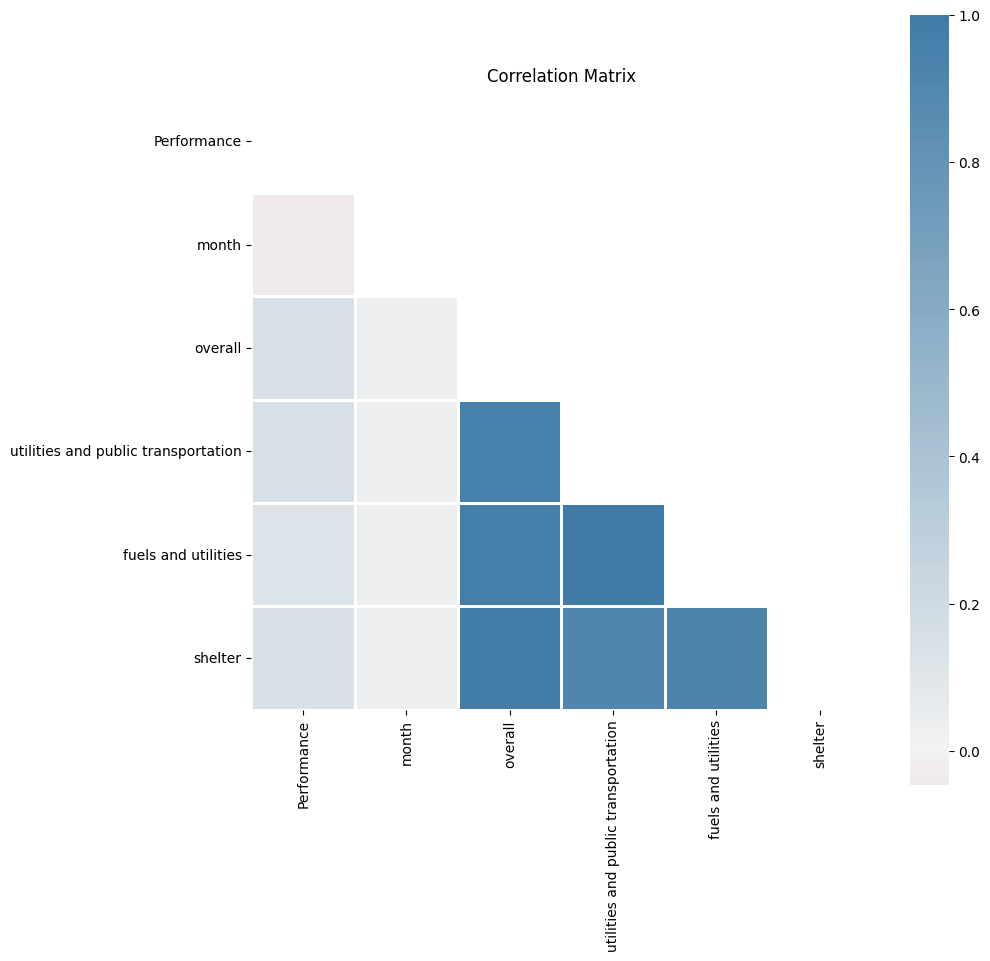

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
0,2015,5,2105.808078,218.187680,-16.672424,-7.475158,257.231727,216.416448,248.458520,330.546691,3
1,2005,5,1139.352462,185.831322,-2.938973,45.045727,200.051479,209.206909,175.027633,210.497563,3
2,2019,5,3796.715016,219.554658,-5.839274,-9.961685,241.659920,211.867989,229.658863,248.709376,3
3,2001,7,1351.848834,210.999951,32.305528,-3.465242,189.595531,167.433499,162.823480,203.976308,3
4,1998,4,1421.227684,151.998608,6.231731,-24.691876,181.929925,165.319424,154.769597,186.617881,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,2002,7,1339.701083,160.076508,-11.824131,-6.919759,222.929892,153.125848,149.258548,206.401390,3
9996,2007,4,1342.714904,193.335269,-12.341340,-16.931207,182.814704,201.853375,203.811862,247.731062,3
9997,2008,4,1136.739425,174.283944,-3.957276,-7.438262,219.045794,196.097120,213.234923,242.906269,3
9998,2006,5,1548.201541,199.072971,9.027254,-8.314224,184.515488,163.827039,158.024906,203.806137,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Utilities (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
samples.head()

,Performance,month,overall,utilities and public transportation,fuels and utilities,shelter
0,1,5,257.231727,216.416448,248.458520,330.546691
1,1,5,200.051479,209.206909,175.027633,210.497563
2,0,5,241.659920,211.867989,229.658863,248.709376
3,0,7,189.595531,167.433499,162.823480,203.976308
4,0,4,181.929925,165.319424,154.769597,186.617881


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,6
Size in Memory,468.9 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.49,0.50,2,5079
month,int64,0,0,1,5,12,4.90,1.56,12,3380
overall,float64,0,0,163.99,228.36,295.85,225.18,29.55,10000,1
utilities and public transportation,float64,0,0,147.55,205.63,239.55,197.40,23.057,10000,1
fuels and utilities,float64,0,0,121.023,217.77,284.52,208.92,39.43,10000,1
shelter,float64,0,0,165.45,253.88,375.18,261.56,46.11,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

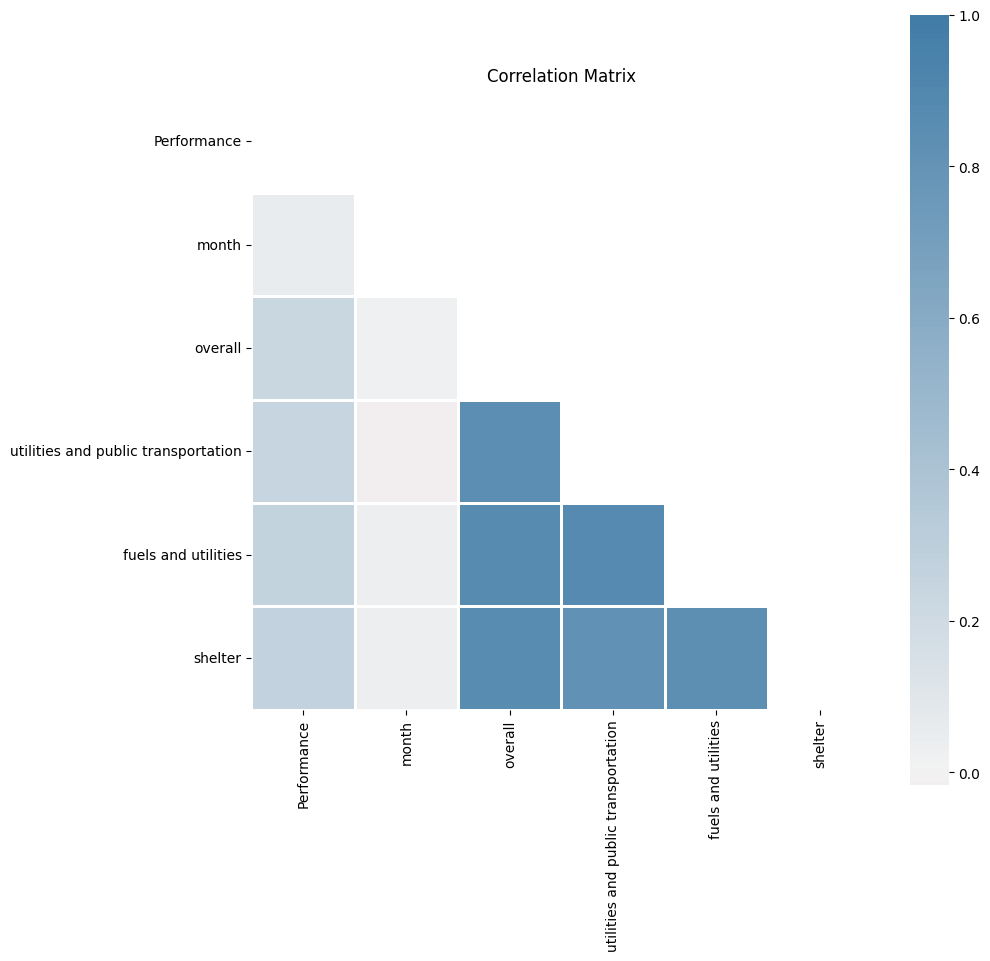

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 5079, 1: 4921})
Counter({1: 5079, 0: 5079})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  257.23172666,   216.41644754,   248.45851977, ...,
        53770.51021022, 71535.74057715, 82127.14151876],
       [  200.0514786 ,   209.20690912,   175.02763273, ...,
        36616.99005367, 44037.54449529, 36842.89011672],
       [  241.65992021,   211.86798933,   229.65886264, ...,
        48657.36145808, 52693.55537307, 57118.31236881],
       ...,
       [  246.708886  ,   211.47297515,   231.09154962, ...,
        48869.61753046, 62626.53913593, 68436.47026514],
       [  279.61844772,   222.35744028,   266.88302946, ...,
        59343.42728636, 78164.05666763, 93815.88586285],
       [  237.84950148,   190.89499666,   212.99281026, ...,
        40659.26180456, 47154.44812147, 52612.9998022 ]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(10158, 11)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(263, 11)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.593032,0.59106,0.603673,0.597214,0.59685,0.584772,0.600806,0.592681,0.562738,0.618644,0.51049,0.559387
1,DecisionTreeClassifier,0.556708,0.556191,0.561146,0.558547,0.54252,0.529456,0.565323,0.546802,0.437262,0.482759,0.48951,0.486111
2,RandomForestClassifier,0.6079,0.605208,0.619432,0.611944,0.609055,0.594347,0.627419,0.610435,0.585551,0.60625,0.678322,0.640264
3,AdaBoostClassifier,0.620301,0.6046,0.695218,0.646623,0.618504,0.590635,0.712097,0.645704,0.581749,0.638655,0.531469,0.580153
4,GradientBoostingClassifier,0.623844,0.611407,0.680257,0.643931,0.617717,0.591809,0.699194,0.641035,0.646388,0.647059,0.769231,0.702875
5,ExtraTreesClassifier,0.603567,0.600072,0.619824,0.609467,0.608268,0.593298,0.628226,0.610262,0.570342,0.6,0.629371,0.614334
6,BaggingClassifier,0.591363,0.603601,0.529652,0.563894,0.583465,0.581688,0.522581,0.550552,0.551331,0.591241,0.566434,0.578571
7,SVC,0.62729,0.612643,0.692264,0.650003,0.62874,0.601922,0.707258,0.650352,0.577947,0.633333,0.531469,0.577947
8,GaussianNB,0.616854,0.606153,0.667652,0.635379,0.620079,0.599566,0.667742,0.63182,0.60076,0.631944,0.636364,0.634146


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.611024,0.595599,0.633065,0.613761


## Using all data

In [22]:
data = pd.read_csv('../data/S&P 500 Utilities 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter,dow
0,1993,5,1993-05-13,439.23,120.120003,-5.758792,8.666548,OUTPERFORM,144.300,134.700,121.400,155.800,3
1,1993,6,1993-06-10,445.38,121.970001,-4.085280,11.714601,OUTPERFORM,144.500,135.100,121.700,155.900,3
2,1993,7,1993-07-08,448.64,126.389999,-0.020057,16.671279,OUTPERFORM,144.800,135.700,122.100,156.200,3
3,1993,8,1993-08-12,448.96,129.559998,-1.830188,27.783804,OUTPERFORM,145.000,136.300,122.500,156.500,3
4,1993,9,1993-09-09,457.50,131.649994,3.319783,36.779215,OUTPERFORM,145.600,136.300,122.600,156.900,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,328.029999,1.147999,-13.070096,UNDERPERFORM,273.092,229.005,262.483,335.888,3
339,2021,8,2021-08-12,4460.83,345.839996,7.276877,-9.221200,UNDERPERFORM,274.214,229.123,265.333,337.298,3
340,2021,9,2021-09-09,4493.28,350.709991,15.209058,-0.842549,UNDERPERFORM,276.590,231.525,270.870,338.865,3
341,2021,10,2021-10-14,4438.26,334.570007,8.483351,-10.828892,UNDERPERFORM,278.524,232.450,271.467,340.475,3


In [23]:
original = data[['S&P 500 Utilities (Sector) Outperform/Underperform','month','overall',\
                                                         'utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
data.drop(columns=['date','S&P 500 Utilities (Sector) Outperform/Underperform'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Utilities (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
0,2009,9,1547.737274,169.067138,-16.049352,-19.581006,221.427938,152.355019,133.729104,204.206297,3
1,2016,8,2657.532459,299.159584,-7.319161,7.671112,246.879074,226.689178,251.933000,295.674939,3
2,2014,9,2425.205621,261.827604,-12.305854,-2.511620,242.969808,207.743262,263.408392,305.753777,3
3,1994,9,1028.587623,125.095103,40.232509,66.185116,149.721611,149.798012,133.621785,159.120875,3
4,2012,7,2329.031026,172.323520,0.053451,-7.152599,241.174909,215.551500,235.823690,261.207987,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,2017,7,2824.088786,263.522214,-11.625679,-0.722396,230.970114,219.787306,235.384822,314.598716,3
9996,2019,9,2527.189168,248.388414,-4.870670,-1.490176,232.459961,229.380451,244.169995,282.066685,3
9997,2013,6,3860.521790,299.144271,-14.974769,0.240191,249.459192,206.367061,232.968658,252.542130,3
9998,2018,6,3110.978016,274.411686,-8.142578,-3.632784,236.587453,214.844127,244.567994,300.624926,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Utilities (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.674857,0.703419,0.610867,0.653043,0.671985,0.703235,0.607165,0.651678,0.603499,0.675926,0.688679,0.682243
1,DecisionTreeClassifier,0.675091,0.693069,0.640018,0.664143,0.663394,0.678804,0.63388,0.655573,0.527697,0.619048,0.613208,0.616114
2,RandomForestClassifier,0.755035,0.795467,0.697871,0.741325,0.72691,0.755571,0.679417,0.715473,0.588921,0.663594,0.679245,0.671329
3,AdaBoostClassifier,0.652217,0.671852,0.595371,0.6312,0.661246,0.686855,0.60595,0.643871,0.548105,0.624454,0.674528,0.648526
4,GradientBoostingClassifier,0.661578,0.673382,0.628359,0.64997,0.675361,0.687699,0.655131,0.67102,0.539359,0.664634,0.514151,0.579787
5,ExtraTreesClassifier,0.774523,0.81503,0.723802,0.763828,0.747162,0.780504,0.695203,0.735389,0.577259,0.64135,0.716981,0.67706
6,BaggingClassifier,0.711072,0.766246,0.615778,0.681325,0.698987,0.744135,0.616272,0.674195,0.565598,0.655172,0.627358,0.640964
7,SVC,0.647844,0.643232,0.664569,0.653582,0.661246,0.660556,0.678203,0.669263,0.618076,0.66805,0.759434,0.710817
8,GaussianNB,0.574344,0.590018,0.488571,0.534391,0.576557,0.599257,0.489375,0.53877,0.562682,0.64486,0.650943,0.647887


## Using data after 2010 (Best Model)

In [25]:
data = pd.read_csv('../data/S&P 500 Utilities 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter,dow
200,2010,1,2010-01-14,1148.46,158.289993,-2.941027,-1.591553,OUTPERFORM,217.281,201.045,212.638,247.997,3
201,2010,2,2010-02-11,1078.47,146.449997,-9.326551,-5.959031,OUTPERFORM,217.353,202.330,214.506,247.914,3
202,2010,3,2010-03-11,1150.24,151.440002,-8.476491,-5.190005,OUTPERFORM,217.403,202.917,214.821,247.959,3
203,2010,4,2010-04-08,1186.44,152.529999,-7.551331,-6.037087,OUTPERFORM,217.290,203.124,214.303,248.128,3
204,2010,5,2010-05-13,1157.44,152.580002,-12.792152,-5.965730,OUTPERFORM,217.199,203.501,213.427,248.295,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,328.029999,1.147999,-13.070096,UNDERPERFORM,273.092,229.005,262.483,335.888,3
339,2021,8,2021-08-12,4460.83,345.839996,7.276877,-9.221200,UNDERPERFORM,274.214,229.123,265.333,337.298,3
340,2021,9,2021-09-09,4493.28,350.709991,15.209058,-0.842549,UNDERPERFORM,276.590,231.525,270.870,338.865,3
341,2021,10,2021-10-14,4438.26,334.570007,8.483351,-10.828892,UNDERPERFORM,278.524,232.450,271.467,340.475,3


In [26]:
original = data[['S&P 500 Utilities (Sector) Outperform/Underperform','month','overall',\
                                                         'utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
data.drop(columns=['date','S&P 500 Utilities (Sector) Outperform/Underperform'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Utilities (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
0,2020,4,2269.141183,264.866518,-18.464189,-1.055084,256.138134,217.420988,239.830357,307.109038,3
1,2012,4,1678.359107,170.662953,-1.147082,0.689846,230.223703,207.194130,212.994854,253.706872,3
2,2016,2,3412.466536,280.832721,-2.591209,-0.350532,251.068261,217.545046,236.924668,294.670048,3
3,2021,4,2838.899881,309.602897,-14.763950,5.860144,272.913033,227.949680,251.223124,324.490420,3
4,2014,4,2710.165310,214.186255,-2.837188,-8.080098,231.400005,215.453871,236.707603,267.851218,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,2020,4,3766.866467,298.034351,-8.808831,-4.816479,246.360411,234.723383,250.299879,301.393259,3
9996,2015,3,2840.270643,258.330508,-5.065765,-8.245819,233.982757,216.954190,250.139867,263.410885,3
9997,2015,4,1955.091992,229.011169,-8.688242,8.010969,238.142996,219.038054,243.064471,300.990109,3
9998,2021,4,3266.812626,347.222243,-2.713063,-0.271822,265.929147,227.614031,272.746061,329.955441,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Utilities (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.696537,0.716431,0.654606,0.683634,0.69545,0.715379,0.669271,0.691557,0.552448,0.65625,0.670213,0.663158
1,DecisionTreeClassifier,0.66997,0.679564,0.652442,0.664879,0.661906,0.673592,0.654297,0.663804,0.58042,0.697674,0.638298,0.666667
2,RandomForestClassifier,0.746773,0.771858,0.7099,0.738126,0.730986,0.752786,0.703776,0.727456,0.503497,0.632184,0.585106,0.607735
3,AdaBoostClassifier,0.688479,0.69638,0.669051,0.682345,0.699768,0.726037,0.660807,0.691888,0.496503,0.6375,0.542553,0.586207
4,GradientBoostingClassifier,0.69454,0.699648,0.682172,0.690708,0.70641,0.723288,0.6875,0.70494,0.51049,0.65,0.553191,0.597701
5,ExtraTreesClassifier,0.762716,0.791787,0.725008,0.754984,0.753238,0.775922,0.725911,0.750084,0.538462,0.659091,0.617021,0.637363
6,BaggingClassifier,0.714389,0.75846,0.636666,0.691087,0.70807,0.752111,0.638021,0.690384,0.503497,0.64557,0.542553,0.589595
7,SVC,0.677849,0.673333,0.690973,0.681978,0.683826,0.68694,0.698568,0.692705,0.48951,0.62963,0.542553,0.582857
8,GaussianNB,0.60611,0.611825,0.581538,0.596176,0.614746,0.632768,0.583333,0.607046,0.51049,0.62766,0.62766,0.62766
